# Solar Orbiter Workshop @GSFC
### Oct 25 2023


![title](./images/sunpy_logo.png)


This notebook is to demonstrate how you can work with Solar Orbiter data with the SunPy ecosystem. 
It serves to demonstate how the SunPy Ecosystem allows you to easily work different types of data using the same set of tools.

Here, I'll demonstrate how you can search for and download Solar Orbiter data. We'll also then look at an event analysis workflow for a large solar eruptive event that occured on Sept 5 2022 by both PSP and Solar Orbiter.



Some useful links:

* An introduction to SunPy https://docs.sunpy.org/en/stable/tutorial/index.html
* Solar Orbiter Archive https://soar.esac.esa.int/soar/
* Summary of SOOPs that have been run: https://www.cosmos.esa.int/web/solar-orbiter/soops-summary
* Inventory plots of data on SOAR: https://www.cosmos.esa.int/web/soar/inventory-plots
* STIX data center: https://datacenter.stix.i4ds.net/stix
* EUI/SIDC Solar Eruption list: https://www.sidc.be/EUI/solar-eruptions
* EPD data loader: https://github.com/jgieseler/solo-epd-loader


In [1]:
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import pandas as pd
from sunpy.net import Fido, attrs as a 
from sunpy.coordinates import frames, get_horizons_coord, get_body_heliographic_stonyhurst
from sunpy.time import parse_time
import sunpy.map
import sunpy.timeseries
import sunpy_soar
from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.visualization import PowerStretch, AsinhStretch, LogStretch
from astropy.wcs import WCS
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import constants as const
from astropy.time import Time
from reproject.mosaicking import reproject_and_coadd
from reproject import reproject_interp
import stixpy
from stixpy.net.client import STIXClient 
import stixpy.timeseries

# 1. How to access and download Solar Orbiter data

## Overview of sunpy's Fido Unified Downloader
Fido is sunpy's interface for searching and downloading solar physics data.
It offers a unified interface for searching and fetching data irrespective of the underlying client or webservice from where the data is obtained.
You can also search and accesses multiple instruments and all available data providers in a single query.
It supplies a single, easy, consistent and extendable way to get most forms of solar physics data the community need.

For more information about Fido and how to use it check out the documentation on our website: https://docs.sunpy.org/en/stable/tutorial/acquiring_data/index.html

Fido offers access to data available through:

* VSO
* JSOC (through drms)
* Individual data providers from web accessible sources (http, ftp, etc)
* CDAWeb
* HEK
* HELIO
  
As described here Fido provides access to many sources of data through different clients, these clients can be defined inside sunpy or in other packages (e.g. DKIST data can be accessed using Fido through [DKIST User Tools](https://docs.dkist.nso.edu/projects/python-tools/en/latest/tutorial/2_search_and_asdf_download.html).


#### Importantly, Solar Orbiter data can be accessed through the client defined in the `sunpy_soar` affiliated package. 
The SOAR client is registered once we install `sunpy_soar` above. Without installing it, it wont be registered within Fido.

Lets first inspect the clients that are available through Fido:

In [ ]:
Fido

Lets inspect what instrument and clients providers are available through Fido. 

In [ ]:
a.Provider

There are also Solar Orbiter specific attributes that are registered when we import `sunpy_soar`, such as `a.soar.Product`, and `a.soar.SOOP` (Solar Orbiter Observing Plan).

What this allows you to do is to construct a query based on these attributes, for example, a specific data product during a specific SOOP etc.

In [ ]:
a.soar.Product

In [ ]:
a.soar.SOOP

## Lets construct a query

To search for data with Fido, you need to specify attributes to search with. These are usually a timerange (`a.Time`), and an instrument (`a.Instrument`). But you can also add lots of different attributes to make your query more specific. It should also be noted that Fido will return all possible results given the conditions of your query, so for example, if two data providers host the same data, it will return two results (for example the VSO provides the EUI data as well as the SOAR). You can also specifiy the provider you want to search for in your query.

Let's search for EUI data over a timerange

In [2]:
res_eui = Fido.search(a.Time("2022-03-25", "2022-03-26"), 
                      a.Instrument("EUI"), 
                      a.Provider.soar)

this returns an [`UnifiedResponse`](https://docs.sunpy.org/en/stable/generated/api/sunpy.net.fido_factory.UnifiedResponse.html#sunpy.net.fido_factory.UnifiedResponse) object (like a table) containing all the search results that match the search attributes. We haven't downloaded anything here, we've just found the results of the query. Lets inspect the table and see whats there:

In [3]:
res_eui

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str3,str16,str2,str23,str23,str43,str52,float64,object
EUI,eui-fsi304-image,L2,2022-03-25 00:08:15.304,2022-03-25 00:08:25.304,solo_L2_eui-fsi304-image_20220325T000815304,solo_L2_eui-fsi304-image_20220325T000815304_V02.fits,4.591,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi304-image,L1,2022-03-25 00:08:15.304,2022-03-25 00:08:25.304,solo_L1_eui-fsi304-image_20220325T000815304,solo_L1_eui-fsi304-image_20220325T000815304_V02.fits,4.095,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi304-image,L3,2022-03-25 00:08:15.304,2022-03-25 00:08:25.304,solo_L3_eui-fsi304-image_20220325T000815304,solo_L3_eui-fsi304-image_20220325T000815304_V02.jp2,2.065,None
EUI,eui-fsi174-image,L2,2022-03-25 00:08:45.303,2022-03-25 00:08:55.303,solo_L2_eui-fsi174-image_20220325T000845303,solo_L2_eui-fsi174-image_20220325T000845303_V02.fits,5.639,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi174-image,L3,2022-03-25 00:08:45.303,2022-03-25 00:08:55.303,solo_L3_eui-fsi174-image_20220325T000845303,solo_L3_eui-fsi174-image_20220325T000845303_V02.jp2,2.146,None
EUI,eui-fsi174-image,L1,2022-03-25 00:08:45.303,2022-03-25 00:08:55.303,solo_L1_eui-fsi174-image_20220325T000845303,solo_L1_eui-fsi174-image_20220325T000845303_V02.fits,5.141,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi304-image,L2,2022-03-25 00:18:15.305,2022-03-25 00:18:25.305,solo_L2_eui-fsi304-image_20220325T001815305,solo_L2_eui-fsi304-image_20220325T001815305_V02.fits,4.651,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi304-image,L1,2022-03-25 00:18:15.305,2022-03-25 00:18:25.305,solo_L1_eui-fsi304-image_20220325T001815305,solo_L1_eui-fsi304-image_20220325T001815305_V02.fits,4.101,L_FULL_HRES_HCAD_Coronal-Dynamics


We can also construct a query to search for SWA data (i.e. in-situ data). We can also specific the level data that we want, here Level 2 data. 

(Note that there's no SOOP name associated in the returned table - thats because the in-situ data products do not have this tied to their data)

In [4]:
res_swa = Fido.search(a.Time("2022-03-25", "2022-03-26"), 
                      a.Instrument("SWA"), 
                      a.Level(2), a.Provider.soar)

In [5]:
res_swa

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str3,str17,str2,str23,str23,str57,str65,float64,object
SWA,swa-pas-grnd-mom,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_swa-pas-grnd-mom_20220325,solo_L2_swa-pas-grnd-mom_20220325_V02.cdf,2.701,None
SWA,swa-pas-eflux,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_swa-pas-eflux_20220325,solo_L2_swa-pas-eflux_20220325_V02.cdf,7.345,None
SWA,swa-pas-vdf,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_swa-pas-vdf_20220325,solo_L2_swa-pas-vdf_20220325_V02.cdf,657.224,None
SWA,swa-eas1-nm3d-psd,L2,2022-03-25 00:00:02.000,2022-03-25 06:05:02.000,solo_L2_swa-eas1-nm3d-psd_20220325T000002-20220325T060502,solo_L2_swa-eas1-nm3d-psd_20220325T000002-20220325T060502_V01.cdf,567.856,None
SWA,swa-eas2-nm3d-psd,L2,2022-03-25 00:00:02.000,2022-03-25 06:05:02.000,solo_L2_swa-eas2-nm3d-psd_20220325T000002-20220325T060502,solo_L2_swa-eas2-nm3d-psd_20220325T000002-20220325T060502_V01.cdf,567.856,None
SWA,swa-eas1-nm3d-dnf,L2,2022-03-25 00:00:02.000,2022-03-25 06:05:02.000,solo_L2_swa-eas1-nm3d-dnf_20220325T000002-20220325T060502,solo_L2_swa-eas1-nm3d-dnf_20220325T000002-20220325T060502_V01.cdf,567.856,None
SWA,swa-eas2-nm3d-dnf,L2,2022-03-25 00:00:02.000,2022-03-25 06:05:02.000,solo_L2_swa-eas2-nm3d-dnf_20220325T000002-20220325T060502,solo_L2_swa-eas2-nm3d-dnf_20220325T000002-20220325T060502_V01.cdf,567.856,None
SWA,swa-eas1-nm3d-def,L2,2022-03-25 00:00:02.000,2022-03-25 06:05:02.000,solo_L2_swa-eas1-nm3d-def_20220325T000002-20220325T060502,solo_L2_swa-eas1-nm3d-def_20220325T000002-20220325T060502_V01.cdf,567.856,None


Say for example, instead we're just interested in data from a particular SOOP. Checkout the [SOOP summary page](https://www.cosmos.esa.int/web/solar-orbiter/soops-summary) for more details.
Lets search for the coronal dynamics SOOP, which focuses on observing structures in the outer corona and linking them to the heliosphere observed in-situ.

In [6]:
res_soop = Fido.search(a.Time("2022-03-25", "2022-03-25 01:00"), 
                  a.soar.SOOP.l_full_hres_hcad_coronal_dynamics, 
                  a.Provider.soar)

In [7]:
res_soop

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str6,str18,str2,str23,str23,str57,str83,float64,str33
METIS,metis-vl-pol-angle,L2,2022-03-25 00:01:01.198,2022-03-25 00:29:45.356,solo_L2_metis-vl-pol-angle_20220325T000101,solo_L2_metis-vl-pol-angle_20220325T000101_V01.fits,12.64,L_FULL_HRES_HCAD_Coronal-Dynamics
METIS,metis-vl-stokes,L2,2022-03-25 00:01:01.198,2022-03-25 00:29:45.356,solo_L2_metis-vl-stokes_20220325T000101,solo_L2_metis-vl-stokes_20220325T000101_V01.fits,21.067,L_FULL_HRES_HCAD_Coronal-Dynamics
METIS,metis-vl-image,L2,2022-03-25 00:01:01.198,2022-03-25 00:28:12.966,solo_L2_metis-vl-image_20220325T000101,solo_L2_metis-vl-image_20220325T000101_V01.fits,12.643,L_FULL_HRES_HCAD_Coronal-Dynamics
METIS,metis-vl-tb,L2,2022-03-25 00:01:01.198,2022-03-25 00:29:45.356,solo_L2_metis-vl-tb_20220325T000101,solo_L2_metis-vl-tb_20220325T000101_V01.fits,12.64,L_FULL_HRES_HCAD_Coronal-Dynamics
METIS,metis-vl-pb,L2,2022-03-25 00:01:01.198,2022-03-25 00:29:45.356,solo_L2_metis-vl-pb_20220325T000101,solo_L2_metis-vl-pb_20220325T000101_V01.fits,12.64,L_FULL_HRES_HCAD_Coronal-Dynamics
METIS,metis-vl-image,L2,2022-03-25 00:01:31.995,2022-03-25 00:28:43.763,solo_L2_metis-vl-image_20220325T000131,solo_L2_metis-vl-image_20220325T000131_V01.fits,12.643,L_FULL_HRES_HCAD_Coronal-Dynamics
METIS,metis-vl-image,L2,2022-03-25 00:02:02.796,2022-03-25 00:29:14.560,solo_L2_metis-vl-image_20220325T000202,solo_L2_metis-vl-image_20220325T000202_V01.fits,12.643,L_FULL_HRES_HCAD_Coronal-Dynamics
SOLOHI,solohi-2ft,L2,2022-03-25 00:02:08.463,2022-03-25 00:02:32.965,solo_L2_solohi-2ft_20220325T000208,solo_L2_solohi-2ft_20220325T000208_V02.fits,3.96,L_FULL_HRES_HCAD_Coronal-Dynamics


We can also search for all data available from the SOAR between two times

In [8]:
res_all_solo_timerange = Fido.search(a.Time("2022-03-25", "2022-03-25 01:00"), 
                                     a.Provider.soar)

In [9]:
res_all_solo_timerange

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str6,str23,str2,str23,str23,str57,str83,float64,object
EPD,epd-sis-b-hehist,L1,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L1_epd-sis-b-hehist_20220325,solo_L1_epd-sis-b-hehist_20220325_V02.cdf,0.006,None
MAG,mag-rtn-normal-1-minute,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_mag-rtn-normal-1-minute_20220325,solo_L2_mag-rtn-normal-1-minute_20220325_V01.cdf,0.033,None
MAG,mag-rtn-normal,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_mag-rtn-normal_20220325,solo_L2_mag-rtn-normal_20220325_V01.cdf,10.868,None
MAG,mag-srf-burst,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_mag-srf-burst_20220325,solo_L2_mag-srf-burst_20220325_V01.cdf,86.211,None
MAG,mag-srf-normal,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_mag-srf-normal_20220325,solo_L2_mag-srf-normal_20220325_V01.cdf,10.875,None
MAG,mag-rtn-burst,L2,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L2_mag-rtn-burst_20220325,solo_L2_mag-rtn-burst_20220325_V01.cdf,86.154,None
MAG,mag-ibs-burst,L1,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L1_mag-ibs-burst_20220325,solo_L1_mag-ibs-burst_20220325_V10.cdf,19.211,None
MAG,mag-obs-burst,L1,2022-03-25 00:00:00.000,2022-03-26 00:00:00.000,solo_L1_mag-obs-burst_20220325,solo_L1_mag-obs-burst_20220325_V10.cdf,145.15,None


We still have not downloaded any data. Lets narrow our search, and only search for EUI L2 data during this SOOP over a short timerange:

In [10]:
res_eui_soop = Fido.search(a.Time("2022-03-25", "2022-03-25 01:00"), 
                           a.soar.SOOP.l_full_hres_hcad_coronal_dynamics, 
                           a.Level(2), a.Provider.soar, a.Instrument("EUI"))

In [11]:
res_eui_soop

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str3,str16,str2,str23,str23,str43,str52,float64,str33
EUI,eui-fsi304-image,L2,2022-03-25 00:08:15.304,2022-03-25 00:08:25.304,solo_L2_eui-fsi304-image_20220325T000815304,solo_L2_eui-fsi304-image_20220325T000815304_V02.fits,4.591,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi174-image,L2,2022-03-25 00:08:45.303,2022-03-25 00:08:55.303,solo_L2_eui-fsi174-image_20220325T000845303,solo_L2_eui-fsi174-image_20220325T000845303_V02.fits,5.639,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi304-image,L2,2022-03-25 00:18:15.305,2022-03-25 00:18:25.305,solo_L2_eui-fsi304-image_20220325T001815305,solo_L2_eui-fsi304-image_20220325T001815305_V02.fits,4.651,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi174-image,L2,2022-03-25 00:18:45.305,2022-03-25 00:18:55.305,solo_L2_eui-fsi174-image_20220325T001845305,solo_L2_eui-fsi174-image_20220325T001845305_V02.fits,5.676,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi304-image,L2,2022-03-25 00:28:15.306,2022-03-25 00:28:25.306,solo_L2_eui-fsi304-image_20220325T002815306,solo_L2_eui-fsi304-image_20220325T002815306_V02.fits,4.74,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi174-image,L2,2022-03-25 00:28:45.306,2022-03-25 00:28:55.306,solo_L2_eui-fsi174-image_20220325T002845306,solo_L2_eui-fsi174-image_20220325T002845306_V02.fits,5.645,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi304-image,L2,2022-03-25 00:38:15.312,2022-03-25 00:38:25.312,solo_L2_eui-fsi304-image_20220325T003815312,solo_L2_eui-fsi304-image_20220325T003815312_V02.fits,4.879,L_FULL_HRES_HCAD_Coronal-Dynamics
EUI,eui-fsi174-image,L2,2022-03-25 00:38:45.316,2022-03-25 00:38:55.316,solo_L2_eui-fsi174-image_20220325T003845316,solo_L2_eui-fsi174-image_20220325T003845316_V02.fits,5.679,L_FULL_HRES_HCAD_Coronal-Dynamics


You can also index the table too.

In [12]:
res_eui_soop[0][2]

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str3,str16,str2,str23,str23,str43,str52,float64,str33
EUI,eui-fsi304-image,L2,2022-03-25 00:18:15.305,2022-03-25 00:18:25.305,solo_L2_eui-fsi304-image_20220325T001815305,solo_L2_eui-fsi304-image_20220325T001815305_V02.fits,4.651,L_FULL_HRES_HCAD_Coronal-Dynamics


### Then to download the files, you can use `Fido.fetch`

Now that we have located the files were interested in via a `Fido.search`, we can download them via `Fido.fetch`.
You pass your query results from `Fido.search` to the `.fetch`. You can also specifiy the path for which to save them locally. Here lets just save them in our current working directory. If you do not pass anything it will save them location set in the sunpy config file.

In [13]:
files = Fido.fetch(res_eui_soop, path="./")

Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

In [14]:
files[0]

'solo_L2_eui-fsi304-image_20220325T000815304_V02.fits'

### You can then read this data into a sunpy.map.Map
Now that we have downloaded the EUI data, we can load it directly into a sunpy [`Map`](https://docs.sunpy.org/en/stable/generated/api/sunpy.map.Map.html#sunpy.map.Map).
You can just pass the fits file. 

To learn more about sunpy maps, you can check out the sunpy tutorial on our docs [here](https://docs.sunpy.org/en/stable/tutorial/maps.html)

In [15]:
eui_map = sunpy.map.Map(files[0])

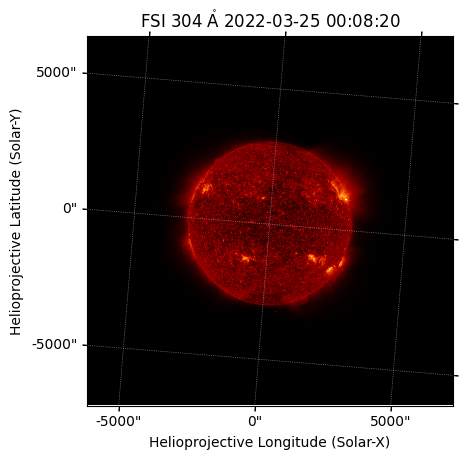

In [16]:
fig = plt.figure()
eui_map.plot()

Lets also have a quick look at downloading some in-situ data and loading it into a sunpy [`TimeSeries`](https://docs.sunpy.org/en/stable/tutorial/timeseries.html).

In [17]:
res_mag = Fido.search(a.Time("2022-03-25", "2022-03-25 23:00"),
                      a.Instrument.mag, 
                      a.soar.Product('mag-rtn-normal-1-minute'), 
                      a.Level(2))

In [18]:
mag_files = Fido.fetch(res_mag, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [19]:
mag_data = sunpy.timeseries.TimeSeries(mag_files)

<Axes: xlabel='EPOCH', ylabel='nT'>

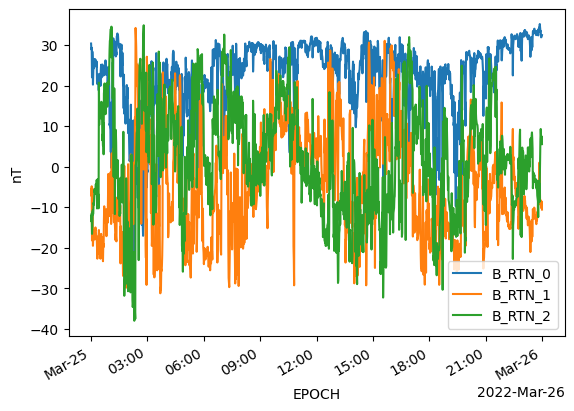

In [20]:
fig = plt.figure()
mag_data.plot(columns=["B_RTN_0", "B_RTN_1", "B_RTN_2"])

# Accessing data from the CDAWeb with sunpy - which is very helpful for in-situ data

There is also a CDAWeb client within sunpy. CDAWeb data can be accessed when the `cdaweb.Dataset` attribute is provided to the search.

The data available from the SOAR is also available from the CDAWeb. You may be used to working with this (especially if you mainly work with in-situ observations), so lets go through how the data can also be accessed this way. This is handy, as you can also access many other in-situ measurements from this too.

In [22]:
a.cdaweb.Dataset

In [23]:
res_cdaw = Fido.search(a.Time("2022-03-25", "2022-03-26"), 
                       a.cdaweb.Dataset('SOLO_L2_MAG-RTN-NORMAL-1-MINUTE'))

In [24]:
res_cdaw

Dataset,Start time,End time,URL
str31,str23,str23,str144
SOLO_L2_MAG-RTN-NORMAL-1-MINUTE,2022-03-25 00:00:29.000,2022-03-25 23:59:30.000,https://cdaweb.gsfc.nasa.gov/sp_phys/data/solar-orbiter/mag/science/l2/rtn-normal-1-minute/2022/solo_l2_mag-rtn-normal-1-minute_20220325_v01.cdf


In [25]:
solo_mag_file = Fido.fetch(res_cdaw, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [26]:
solo_mag_ts = sunpy.timeseries.TimeSeries(solo_mag_file)

<Axes: xlabel='EPOCH', ylabel='nT'>

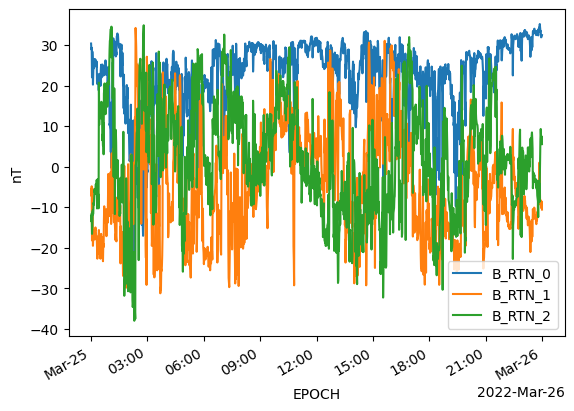

In [27]:
fig = plt.figure()
solo_mag_ts.plot(columns=["B_RTN_0", "B_RTN_1", "B_RTN_2"])

# 2. Scientific Workflow within the SunPy Ecosystem

Lets do an event study with Solar Orbiter and PSP observations to demonstrate a workflow of using the SunPy ecosystem to perform this analysis.

We'll choose a lage eruptive event that occured last September on the backside of the disk as seen from Earth.

In [28]:
tstart = parse_time("2022-09-05 14:30")
tend = parse_time("2022-09-05 21:30")

#### Lets first get the positions  of the spacecraft 

To get the position of the spacecraft to get an overview of where they were with respect to each other, we can use the `get_horizons_coord` function within `sunpy.coordinates` which queries JPL horizons for solar system bodies. Note that there are probably other situations for when you want the info from SPICE kernals - this is something you can do with the [astrospice](https://astrospice.readthedocs.io/en/stable/) package (and soon within sunpy). But for what we need here, the JPL Horizons query will do! 

In [29]:
solo_coord = get_horizons_coord("solo", tstart)
psp_coord =  get_horizons_coord("psp", tstart)
earth_coord =  get_body_heliographic_stonyhurst("earth", tstart)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]


INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


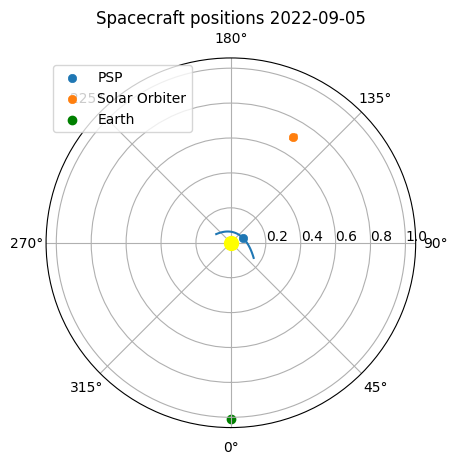

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection="polar")

ax.scatter(psp_coord.lon.to('rad'), psp_coord.radius.to(u.AU),
           label='PSP', lw=0.5)
ax.scatter(solo_coord.lon.to('rad'), solo_coord.radius.to(u.AU),
           label='Solar Orbiter', lw=0.5)
ax.scatter(earth_coord.lon.to('rad'), earth_coord.radius.to(u.AU),
           label='Earth', color='g')
ax.plot(0, 0, marker='o', ms=10, color='yellow')


# lets also get the positions over 4 days to see the perihelion of PSP
# when plotted here, you can't see Solar Orbiter move too much (dot plotted is bigger than movement)
psp_seq = get_horizons_coord("psp", tstart+np.arange(-2, 2, 0.1)*u.day)
solo_seq = get_horizons_coord("solo", tstart + np.arange(-2, 2, 0.1)*u.day)
for coord in [psp_seq, solo_seq]:
    ax.plot(coord.lon.to('rad'), coord.radius.to(u.AU))

ax.set_theta_zero_location("S")
ax.set_rlabel_position(90)
ax.set_title("Spacecraft positions {:s}".format(tstart.strftime("%Y-%m-%d")))
ax.legend(loc="upper left")

## Lets look for the STIX quicklook observations to get an idea of the flare time

In [31]:
stix_ql_query = Fido.search(a.Time(tstart, tend), a.Instrument.stix,
                            a.stix.DataProduct.ql_lightcurve)

In [32]:
Fido.fetch(stix_ql_query, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['solo_L1_stix-ql-lightcurve_20220905_V01.fits']

In [33]:
stix_ts = sunpy.timeseries.TimeSeries("solo_L1_stix-ql-lightcurve_20220905_V01.fits").truncate(tstart.datetime, tend.datetime)

[[<matplotlib.lines.Line2D at 0x131e3c7d0>],

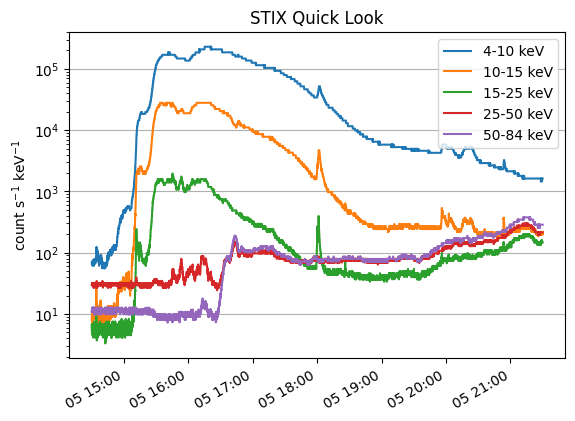

In [34]:
stix_ts.plot()

In [35]:
flare_time = stix_ts.time[np.argmax(stix_ts.quantity("4-10 keV"))]

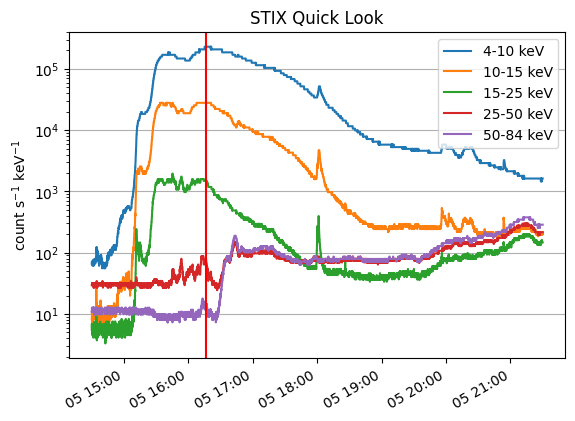

In [36]:
fig, ax = plt.subplots()
stix_ts.plot(axes=ax)
ax.axvline(flare_time.datetime, color='r')

## Lets search for some EUI & PHI data for this event

In [37]:
eui_query = Fido.search(a.Time(tstart, tend), 
                        a.soar.Product("eui-fsi304-image") |  a.soar.Product("eui-fsi174-image") , 
                        a.Level(2))

In [38]:
phi_query = Fido.search(a.Time(tstart, tend), 
                        a.Instrument.phi, a.soar.Product('phi-fdt-blos'),
                        a.Level(2))

In [39]:
phi_query

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str3,str12,str2,str23,str23,str36,str45,float64,object
PHI,phi-fdt-blos,L2,2022-09-05 16:00:09.868,2022-09-05 16:01:10.904,solo_L2_phi-fdt-blos_20220905T160009,solo_L2_phi-fdt-blos_20220905T160009_V01.fits,3.43,None
PHI,phi-fdt-blos,L2,2022-09-05 19:00:09.777,2022-09-05 19:01:10.933,solo_L2_phi-fdt-blos_20220905T190009,solo_L2_phi-fdt-blos_20220905T190009_V01.fits,3.43,None


In [40]:
downloaded_files = Fido.fetch(eui_query, phi_query, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/72 [00:00<?, ?file/s]

In [41]:
downloaded_files[10]

'EUI/solo_L2_eui-fsi304-image_20220905T170020287_V01.fits'

### Lets load the PHI data into a Map
See Jonas Sinjan's [tutorial](https://github.com/JonasSinjan/Solar_Orbiter_PHI_Data_Tutorial/tree/main) later today

In [42]:
phi_maps = sunpy.map.Map("./PHI/*.fits")

In [43]:
len(phi_maps)

2

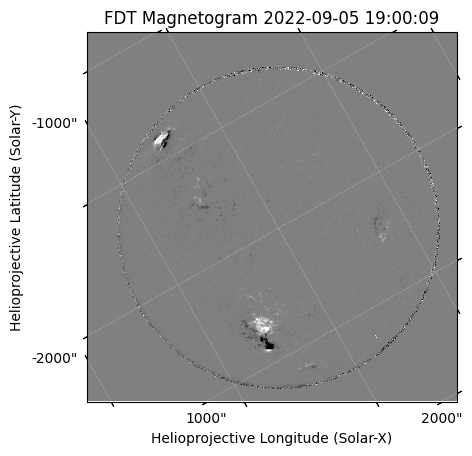

In [44]:
fig = plt.figure()
phi_maps[1].plot(vmin=-500, vmax=500)

In [45]:
phi_maps = [m.rotate(missing=0) for m in phi_maps]

(<matplotlib.patches.Circle at 0x1323445d0>, None)

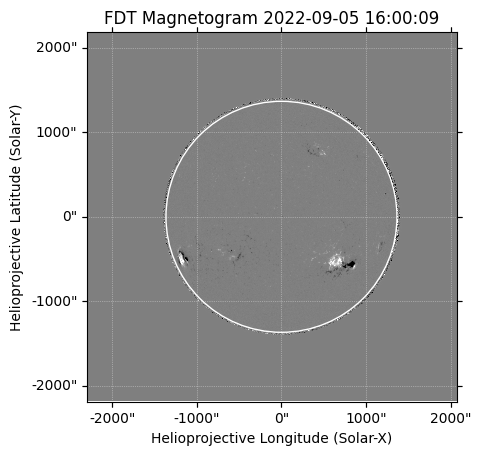

In [46]:
fig = plt.figure()
phi_maps[0].plot(vmin=-500, vmax=500)
phi_maps[0].draw_limb()

# Lets load the EUI maps

In [47]:
eui_maps_174 = sunpy.map.Map("./EUI/*fsi174*")

In [48]:
len(eui_maps_174)

42

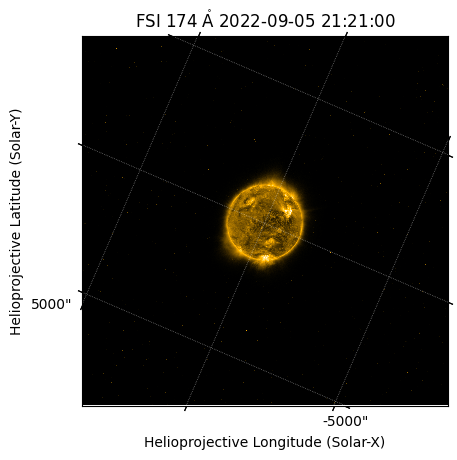

In [49]:
fig = plt.figure()
eui_maps_174[-1].plot()

In [50]:
def make_subs(m):
    bl = SkyCoord(-1800*u.arcsec, -1800*u.arcsec, frame=m.coordinate_frame)
    tr = SkyCoord(1800*u.arcsec, 1800*u.arcsec, frame=m.coordinate_frame)
    return m.submap(bl, top_right=tr).rotate(missing=0)

In [51]:
eui_subs_174 = sunpy.map.Map([make_subs(m) for m in eui_maps_174], sequence=True)

In [52]:
fig = plt.figure()
ani = eui_subs_174.plot()
ani.save("eui_movie_174.mp4")
plt.close()

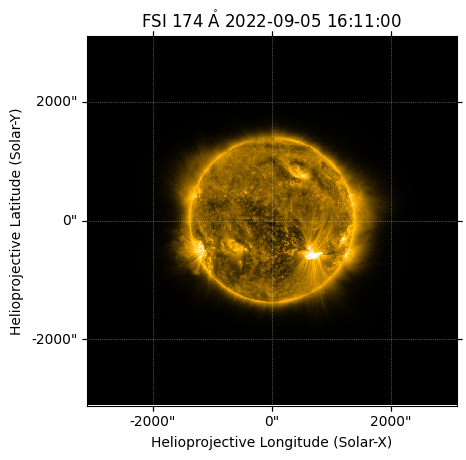

In [53]:
fig = plt.figure()
eui_subs_174[10].plot()

Lets draw a rectangle around the flaring region of interest. 

This can be done using [`sunpy.map.GenericMap.draw_quadrangle`](https://docs.sunpy.org/en/stable/generated/api/sunpy.map.GenericMap.html#sunpy.map.GenericMap.draw_quadrangle)

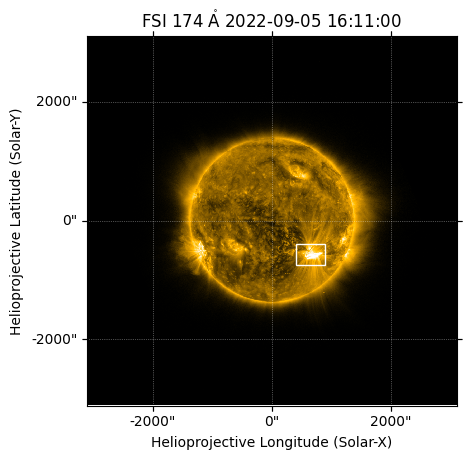

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection=eui_subs_174[10])
eui_subs_174[10].plot()
eui_subs_174[10].draw_quadrangle(SkyCoord(400*u.arcsec, -750*u.arcsec, frame=eui_subs_174[10].coordinate_frame),
                                 top_right=SkyCoord(900*u.arcsec, -400*u.arcsec, frame=eui_subs_174[10].coordinate_frame))

We can also make a running difference movie

# Lets see what this looks like from PSP point of view

We can use the coordinates framework with sunpy to reproject images from one viewpoint to another.
To learn more about this, check out our documentation, and also [this](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_different_observers.html#sphx-glr-generated-gallery-map-transformations-reprojection-different-observers-py) example in the example gallery.

In [55]:
ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                     frame='helioprojective', 
                     obstime=eui_subs_174[0].date, 
                     observer=get_horizons_coord("psp", eui_subs_174[0].date))

# Create a FITS WCS header for the reference coordinate and frame
header = sunpy.map.make_fitswcs_header((3000, 3000),
                                        ref_coord,
                                        scale=[16, 16]*u.arcsec/u.pix,
                                      )



INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]


In [56]:
eui_subs_psp = eui_subs_174[0].reproject_to(header)

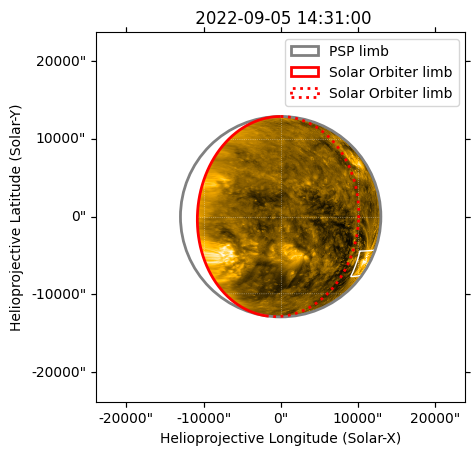

In [57]:
fig = plt.figure()
eui_subs_psp.plot()
eui_subs_psp.draw_limb(color='grey', lw=2, label="PSP limb")
eui_subs_174[0].draw_limb(color='red', lw=2, label="Solar Orbiter limb")
plt.legend()
eui_subs_174[10].draw_quadrangle(SkyCoord(400*u.arcsec, -750*u.arcsec, frame=eui_subs_174[10].coordinate_frame),
                                 top_right=SkyCoord(900*u.arcsec, -400*u.arcsec, frame=eui_subs_174[10].coordinate_frame))

## Lets look for some in-situ data

In [58]:
tstart_insitu = "2022-09-04"
tend_insitu = "2022-09-08"

In [59]:
res_solo_mag = Fido.search(a.Time(tstart_insitu, tend_insitu), 
                           a.cdaweb.Dataset('SOLO_L2_MAG-RTN-NORMAL-1-MINUTE'))
f_solomag = Fido.fetch(res_solo_mag, path="./")
solo_mag = sunpy.timeseries.TimeSeries(f_solomag, concatenate=True)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

<Axes: xlabel='EPOCH', ylabel='nT'>

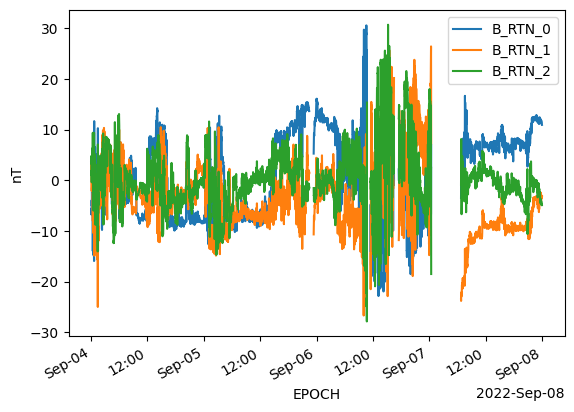

In [60]:
fig = plt.figure()
solo_mag.plot(columns=["B_RTN_0", "B_RTN_1", "B_RTN_2"])

In [61]:
res_solo_swa = Fido.search(a.Time(tstart_insitu, tend_insitu), 
                           a.cdaweb.Dataset.solo_l2_swa_pas_grnd_mom)
f_soloswa = Fido.fetch(res_solo_swa, path="./")
solo_swa_pas = sunpy.timeseries.TimeSeries(f_soloswa, concatenate=True)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

In [62]:
solo_swa_pas.columns

['Half_interval',
 'Info',
 'N',
 'P_RTN_0',
 'P_RTN_1',
 'P_RTN_2',
 'P_RTN_3',
 'P_RTN_4',
 'P_RTN_5',
 'P_SRF_0',
 'P_SRF_1',
 'P_SRF_2',
 'P_SRF_3',
 'P_SRF_4',
 'P_SRF_5',
 'SCET',
 'T',
 'TxTyTz_RTN_0',
 'TxTyTz_RTN_1',
 'TxTyTz_RTN_2',
 'TxTyTz_SRF_0',
 'TxTyTz_SRF_1',
 'TxTyTz_SRF_2',
 'V_RTN_0',
 'V_RTN_1',
 'V_RTN_2',
 'V_SOLO_RTN_0',
 'V_SOLO_RTN_1',
 'V_SOLO_RTN_2',
 'V_SRF_0',
 'V_SRF_1',
 'V_SRF_2',
 'quality_factor',
 'total_count',
 'unrecovered_count']

<Axes: xlabel='Epoch', ylabel='1 / cm3'>

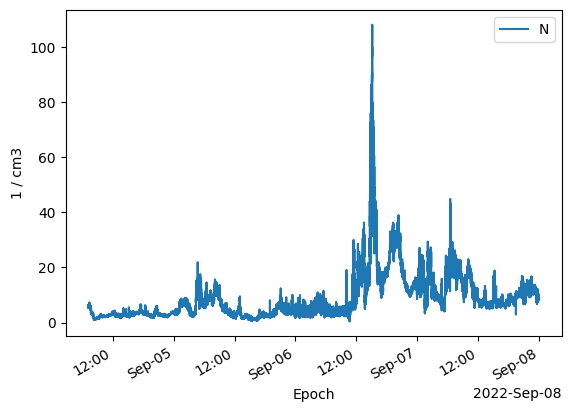

In [63]:
fig = plt.figure()
solo_swa_pas.plot(columns=["N"])

<Axes: xlabel='Epoch', ylabel='eV'>

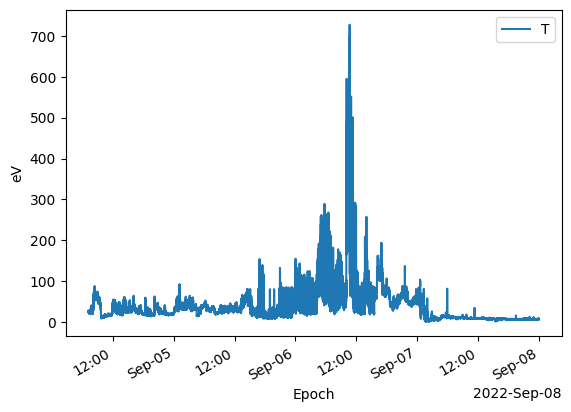

In [64]:
fig = plt.figure()
solo_swa_pas.plot(columns=["T"])

## Lets also look for some PSP FIELDS/MAG data

In [65]:
result_psp_mag = Fido.search(a.Time(tstart_insitu, tend_insitu), 
                             a.cdaweb.Dataset.psp_fld_l2_mag_rtn_1min)
f_mag_psp = Fido.fetch(result_psp_mag, path="./")

psp_mag = sunpy.timeseries.TimeSeries(f_mag_psp, concatenate=True)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

In [66]:
clean_psp = psp_mag._data[psp_mag._data["psp_fld_l2_quality_flags"].isnull()]
psp_event = sunpy.timeseries.TimeSeries(clean_psp, psp_mag.meta, psp_mag.units)

<Axes: ylabel='nT'>

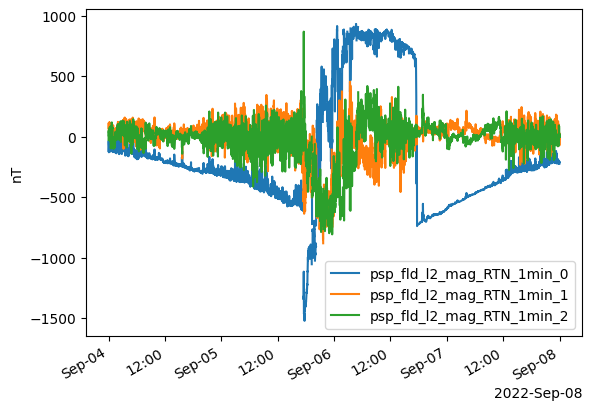

In [67]:
fig = plt.figure()
psp_event.plot(columns=['psp_fld_l2_mag_RTN_1min_0', 
                        'psp_fld_l2_mag_RTN_1min_1',
                        'psp_fld_l2_mag_RTN_1min_2'])

# Lets plot all of these together

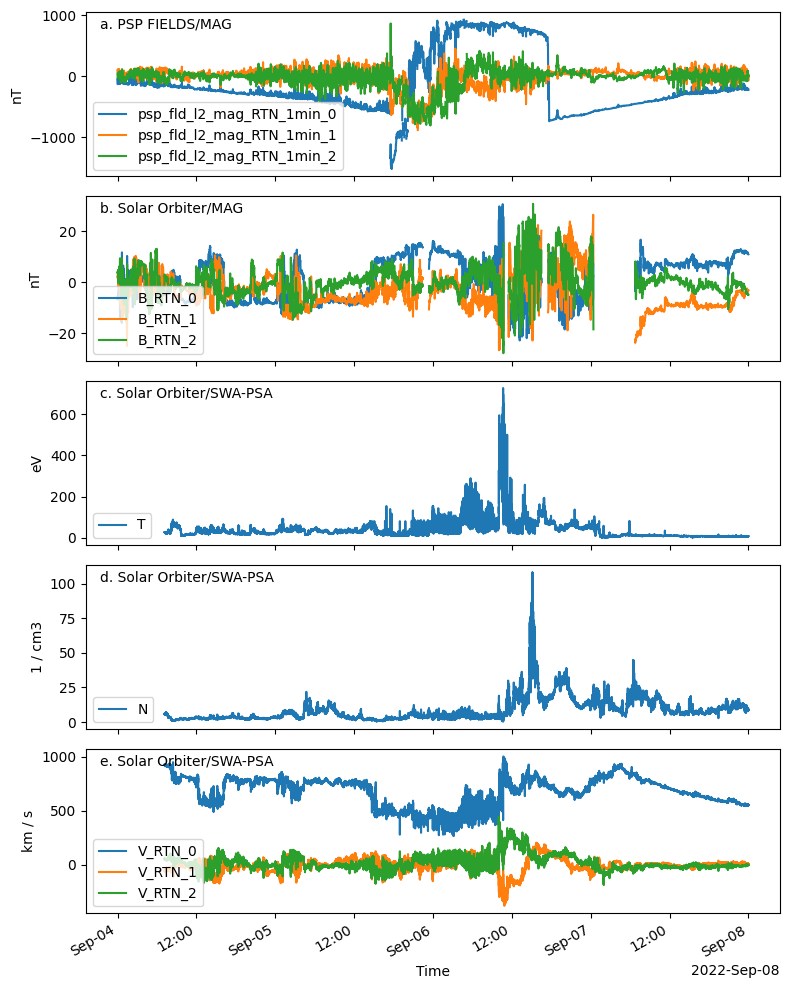

In [68]:
fig, ax = plt.subplots(5, figsize=(8, 10), sharex=True)

psp_event.plot(columns=['psp_fld_l2_mag_RTN_1min_0', 
                        'psp_fld_l2_mag_RTN_1min_1',
                        'psp_fld_l2_mag_RTN_1min_2'], 
              axes=ax[0])
solo_mag.plot(columns=['B_RTN_0', 'B_RTN_1', 'B_RTN_2'], axes=ax[1])
solo_swa_pas.plot(columns=['T'], axes=ax[2])
solo_swa_pas.plot(columns=['N'], axes=ax[3])
solo_swa_pas.plot(columns=['V_RTN_0', 'V_RTN_1', 'V_RTN_2'], axes=ax[4])
ax[4].set_xlabel("Time")

for aa in ax:
    aa.legend(loc="lower left")
    # aa.axvline(flare_time.datetime, color='r')

ax[0].text(0.02, 0.90, "a. PSP FIELDS/MAG", transform=ax[0].transAxes)
ax[1].text(0.02, 0.90, "b. Solar Orbiter/MAG", transform=ax[1].transAxes)
ax[2].text(0.02, 0.90, "c. Solar Orbiter/SWA-PSA", transform=ax[2].transAxes)
ax[3].text(0.02, 0.90, "d. Solar Orbiter/SWA-PSA", transform=ax[3].transAxes)
ax[4].text(0.02, 0.90, "e. Solar Orbiter/SWA-PSA", transform=ax[4].transAxes)

plt.tight_layout()

## Lets look at WISPR data for this event!

In [69]:
res_wispr = Fido.search(a.Time(tstart, tend), 
                        a.Instrument("WISPR"), a.Level(3))

In [70]:
Fido.fetch(res_wispr, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/76 [00:00<?, ?file/s]

['WISPR/psp_l3_wispr_20220905t143016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t143508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t144516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t145008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t150016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t150508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t151516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t152008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t153016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t153508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t154516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t155008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t160016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t160508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t161516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t162008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t163016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t163508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t164516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t1

In [71]:
wispr_outer_maps = sunpy.map.Map("./WISPR/*_2222.fits")
wispr_inner_maps = sunpy.map.Map("./WISPR/*_1211.fits")

In [72]:
wispr_norm = ImageNormalize(stretch=PowerStretch(1/2.2))

In [73]:
vmax_inner = 1.545e-11
vmax_outer = .5e-11

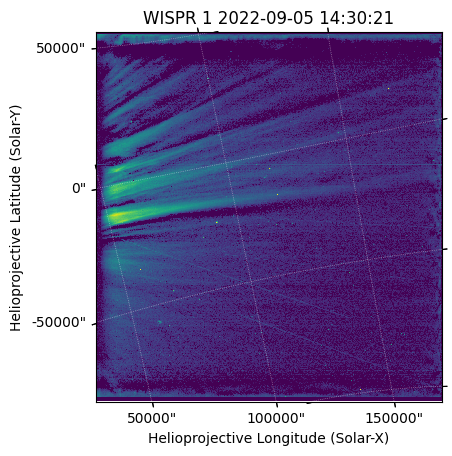

In [74]:
fig = plt.figure()
wispr_inner_maps[0].plot(vmin=0, vmax=0.5e-11, norm=wispr_norm, cmap="viridis")


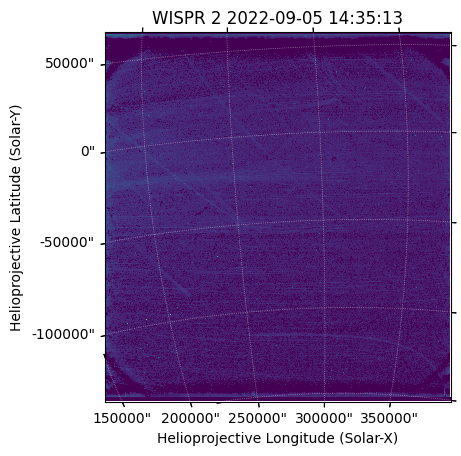

In [75]:
fig = plt.figure()
wispr_outer_maps[0].plot(vmin=0, vmax=0.5e-11, norm=wispr_norm, cmap="viridis")

In [76]:
def combine_wispr_maps(inner_map, outer_map):
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                         frame=frames.Helioprojective(observer=inner_map.observer_coordinate, obstime=inner_map.date))
    
    
    outshape = (360*2, int(360*3.5))
    new_header = sunpy.map.make_fitswcs_header(outshape, 
                                  ref_coord,
                                  reference_pixel=u.Quantity([40*u.pixel, 500*u.pixel]), 
                                  scale=u.Quantity([0.1*u.deg/u.pixel, 0.1*u.deg/u.pixel]), 
                                  projection_code="CAR"
                                 )
    
    out_wcs = WCS(new_header)
    with frames.Helioprojective.assume_spherical_screen(inner_map.observer_coordinate):
        array, footprint = reproject_and_coadd((inner_map, outer_map), out_wcs, outshape,
                                               reproject_function=reproject_interp)

    combined_map = sunpy.map.Map((array, new_header))
    combined_map.plot_settings["norm"] = ImageNormalize(stretch=PowerStretch(1/2.2), vmin=0, vmax=1e-11)
    combined_map.plot_settings["cmap"] = "viridis"
    return combined_map

In [77]:
combined_wispr = combine_wispr_maps(wispr_inner_maps[0], wispr_outer_maps[0])

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

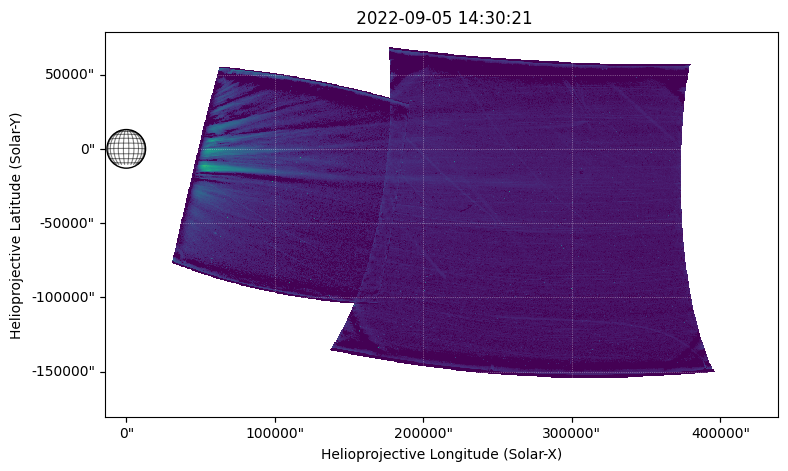

In [78]:
fig = plt.figure(figsize=(10, 5))
combined_wispr.plot(cmap="viridis")
combined_wispr.draw_limb(color='k')
combined_wispr.draw_grid(color='k')

In [79]:
combined_wispr_maps = sunpy.map.Map([combine_wispr_maps(wispr_inner_maps[i], wispr_outer_maps[i]) for i in range(len(wispr_inner_maps))], sequence=True)

In [80]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=combined_wispr_maps[0])
ani = combined_wispr_maps.plot(norm=ImageNormalize(stretch=PowerStretch(1./2.2), vmin=0, vmax=1e-11), cmap="viridis", axes=ax)
combined_wispr_maps[0].draw_limb(color='k')
# ani.save("wispr_movie.mp4")
plt.close()

# Calculate light travel time between WISPR maps and EUI map times

Lets try plot the EUI and WISPR maps on the same figure. However we need to take into account light travel time, as PSP is much closer in that Solar Orbiter. 
This is something that will also need to be taken into account in other studies when comparing Solar Orbiter with Earth-based observatories such as SDO/AIA etc. 

Lets first get the times of each of the maps

In [81]:
wispr_map_times = Time([m.date for m in combined_wispr_maps])
eui_map_times = Time([m.date for m in eui_subs_174])

Now lets get the coordinates of Solar Orbiter at the times of the WISPR maps

In [82]:
solo_coords_at_psp_times = get_horizons_coord("solo", wispr_map_times)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


Calculate the light travel time - we can do this by diving the distance by travel time (i.e. speed of light)

In [83]:
((solo_coords_at_psp_times[0].radius - combined_wispr_maps[0].observer_coordinate.radius)/const.c).to(u.s)

<Quantity 314.09073375 s>

Lets calculate it for each map - you could just use the one time but as PSP is moving quite fast, lets do it for each frame

In [84]:
psp_times_at_solo = [((solo_coords_at_psp_times[i].radius - combined_wispr_maps[i].observer_coordinate.radius)/const.c).to(u.s) for i in range(len(combined_wispr_maps))]

So the time at Solar Orbiter at each WISPR map times is the PSP time + light travel time

In [85]:
wispr_map_times[11]+psp_times_at_solo[11]

<Time object: scale='utc' format='isot' value=2022-09-05T17:20:37.218>

Lets find the EUI map index that has the closest time as this

In [86]:
np.argmin(np.abs(eui_map_times - (wispr_map_times[10]+psp_times_at_solo[10])))

15

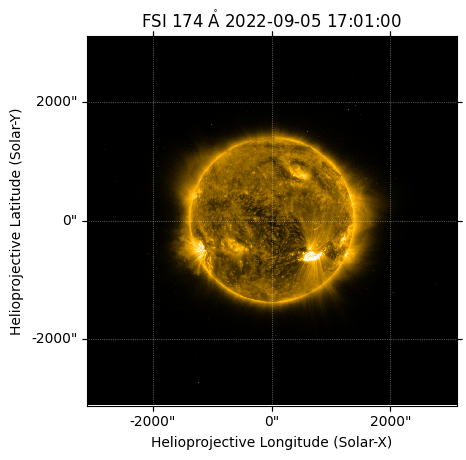

In [87]:
fig = plt.figure()
eui_subs_174[15].plot()

We can reproject the EUI map at this time to the WCS of the combined WISPR map

In [88]:
reprojected_eui =eui_subs_174[15].reproject_to(combined_wispr_maps[11].wcs)

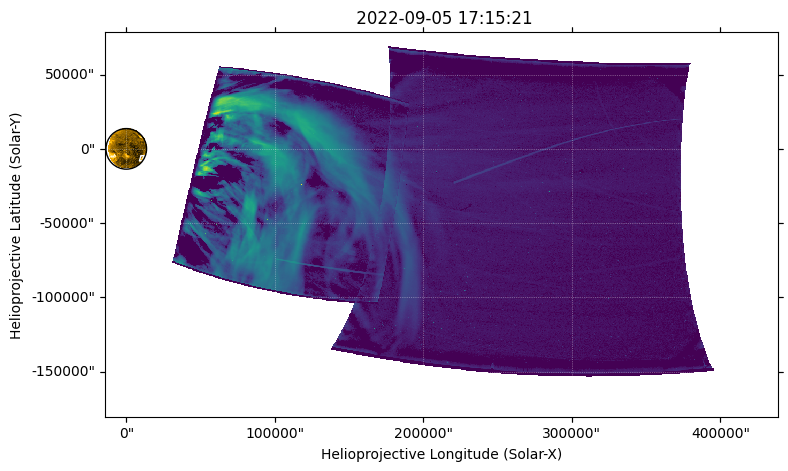

In [89]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=combined_wispr_maps[11])
combined_wispr_maps[11].plot(norm=ImageNormalize(stretch=PowerStretch(1./2.2), vmin=0, vmax=1e-11), cmap="viridis")
reprojected_eui.plot()
reprojected_eui.draw_limb(color='k')
eui_subs_174[10].draw_quadrangle(SkyCoord(400*u.arcsec, -750*u.arcsec, frame=eui_subs_174[10].coordinate_frame),
                                 top_right=SkyCoord(900*u.arcsec, -400*u.arcsec, frame=eui_subs_174[10].coordinate_frame))